# Solution for Solana Skill Sprint - Memcoin Graduation competition

The goal is to predict meme coin graduation.

Data sources are the primary train/test datasets, onchain token information, Dune analytics data, permitted Pump Fun API data, and detailed transaction logs.

Transaction data is filtered to include only activity within the first 100 blocks after each token's creation slot for feature engineering. Feature engineering is time-aware using slot numbers.

Feature engineering includes metadata-based features (presence of links, text characteristics, creation parameters), cumulative statistics tracking historical activity of creators and wallets (specific to each token's 100-block window), TF-IDF features derived from token text fields (fitted only on the training set to prevent data leakage), and transaction-based metrics.

For prediction, an XGBoost classification model is employed within a stratified K-Fold cross-validation framework. Cross-validation is not time aware so validation scores should be taken with a grain of salt.

The final test set predictions are produced by ensembling (averaging) the probabilistic outputs from the five fold XGBoost models.

In [1]:
!pip install -q polars xgboost

In [2]:
import os
import polars as pl
import pandas as pd

import matplotlib.pyplot as plt

import glob
from tqdm import tqdm
import gc
import time

from sklearn.feature_extraction.text import TfidfVectorizer
import re

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
DATA_DIR = "data/pump-fun-graduation-february-2025" # NB! Set this to the correct directory
PUMP_FUN_DATA_DIR = "data/pump-fun-api-solana-tokens-info" # NB! Set this to the correct directory

## Load train and test and keep only is_valid=True

Train samples: 639,557 (57.19%)
Test samples: 478,832 (42.81%)

Target Distribution in Train Set:
                Count  Percentage
has_graduated                    
False          632153       98.84
True             7404        1.16


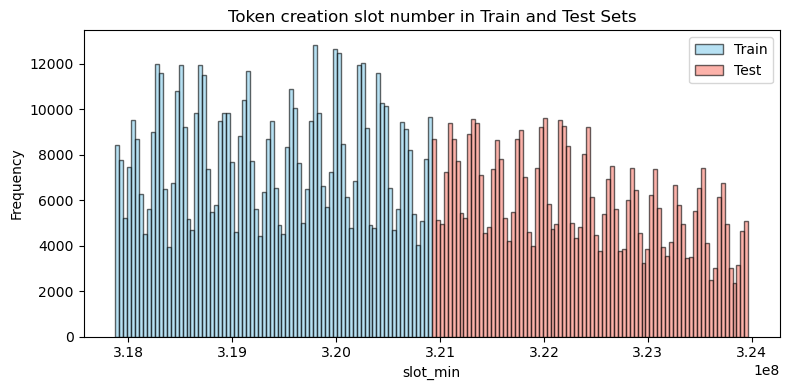

In [4]:
MINT_ID = 'mint'

# Reading the CSV files with pandas
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), index_col=0).drop(columns=['slot_graduated'])
test = pd.read_csv(os.path.join(DATA_DIR, 'test_unlabeled.csv'), index_col=0)

# is_valid False will not be scored but need to be predicted
test = test.drop(columns=['is_valid'])

# Print number and percentage of train vs test samples
n_train = train.shape[0]
n_test = test.shape[0]
total = n_train + n_test

print(f"Train samples: {n_train:,} ({n_train / total:.2%})")
print(f"Test samples: {n_test:,} ({n_test / total:.2%})")

# Target distribution in train set
is_graduated_counts = train['has_graduated'].value_counts().sort_index()

# Create a DataFrame for better formatting
target_dist_df = pd.DataFrame({
    "Count": is_graduated_counts.values,
    "Percentage": (is_graduated_counts.values / n_train * 100).round(2)
}, index=is_graduated_counts.index)

print("\nTarget Distribution in Train Set:")
print(target_dist_df)

# Plot train and test slot_min on the same histogram
plt.figure(figsize=(8, 4))
plt.hist(train['slot_min'], bins=80, alpha=0.6, label='Train', color='skyblue', edgecolor='black')
plt.hist(test['slot_min'], bins=80, alpha=0.6, label='Test', color='salmon', edgecolor='black')
plt.title('Token creation slot number in Train and Test Sets')
plt.xlabel('slot_min')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


Feature engineering must be time-aware and we can use slot number for that.

In [5]:
# Let's combine train and test for easier processing
train['is_train'] = 1
test['is_train'] = 0

# Concatenating the DataFrames
combined_df = pd.concat([train, test])

combined_df = combined_df.drop(columns=['is_valid']) # No longer needed as filtered out

combined_df.sample(3)

,mint,slot_min,has_graduated,is_train
643652,6NNuscnzd2Zho6y4dyKe2KtPqPX5Fm37t7ctW7zNpump,320147641,False,1
382577,9Kfu8e1Gs3nKG3SDZqAK3z1zwTgEsrot2q1SBwKppump,319112229,False,1
29878,BH1V2scqV3p2dYJ4ywpG4H9vvSU2cq7g9XghuPvTP2Fg,321090223,NaN,0


# Onchain info

In [6]:
# Reading the token deployment data
# Using pandas until onchain has been merged because polars had some dtype issues for onchain v2 mint values but not v1
onchain_info_v2 = pd.read_csv(os.path.join(DATA_DIR, 'token_info_onchain_divers_v2.csv'))

# Rename column 'creator' to 'creator_onchain'
onchain_info_v2.rename(columns={'creator': 'creator_onchain'}, inplace=True)

onchain_info_v2 = onchain_info_v2.drop(columns=['tx_idx','symbol','name','bundle_structure','version','curve_address','slot','url'])

# Merge the two dataframes on the 'mint' column
combined_df = pd.merge(combined_df, onchain_info_v2, on='mint', how='left')

combined_df = pl.from_pandas(combined_df)

## Dune info

In [7]:
dune_token_info = pl.read_csv(os.path.join(DATA_DIR, 'dune_token_info.csv'))
dune_token_info = dune_token_info.select(['token_mint_address','decimals']) # Selecting only decimals
combined_df = combined_df.join(dune_token_info, left_on=MINT_ID, right_on='token_mint_address', how='left')

In [8]:
dune_token_info.describe()

statistic,token_mint_address,decimals
str,str,f64
"""count""","""947474""",947474.0
"""null_count""","""0""",0.0
"""mean""",null,6.003472
"""std""",null,0.106461
"""min""","""112GXdaoTJN4nrL2P2Gc3vXKSkHmTf…",2.0
"""25%""",null,6.0
"""50%""",null,6.0
"""75%""",null,6.0
"""max""","""zzys6vjhWhgnTKGv2vztZoKYQ1zqkj…",18.0


## The only allowed external dataset: Gleb's Pump Fun API data

External Pump Fun API data that was allowed.
https://www.kaggle.com/datasets/dremovd/pump-fun-graduation-february-2025

In [9]:
pump_fun_info = pl.read_parquet(os.path.join(PUMP_FUN_DATA_DIR, 'pump_fun_api_info.parquet'))
pump_fun_info = pump_fun_info.drop('initialized','show_name', 'metadata_uri')

In [10]:
pump_fun_info.describe()

statistic,mint,name,symbol,description,image_uri,twitter,telegram,bonding_curve,associated_bonding_curve,creator,created_timestamp,website,video_uri,nsfw
str,str,str,str,str,str,str,str,str,str,str,f64,str,str,f64
"""count""","""1304640""","""1304637""","""1304636""","""1282183""","""1296686""","""674985""","""214861""","""1304640""","""1304640""","""1304640""",1.30464e6,"""558105""","""2973""",1.30464e6
"""null_count""","""0""","""3""","""4""","""22457""","""7954""","""629655""","""1089779""","""0""","""0""","""0""",0.0,"""746535""","""1301667""",0.0
"""mean""",null,null,null,null,null,null,null,null,null,null,1.7386e12,null,null,0.014854
"""std""",null,null,null,null,null,null,null,null,null,null,3.2575e9,null,null,null
"""min""","""112GXdaoTJN4nrL2P2Gc3vXKSkHmTf…","""""","""""","""""","""""","""""","""""","""11399n7HGvExeU1AVikF65YRc1Za2U…","""1117LgNJELR6HU9FuYREDD3sEYVb1c…","""11111FjAxdxBKfoqbN8qkZ2TATyvGt…",1.7062e12,"""""","""https://firebase-vieo-link""",0.0
"""25%""",null,null,null,null,null,null,null,null,null,null,1.7386e12,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null,null,1.7392e12,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null,null,1.7399e12,null,null,null
"""max""","""zzys6vjhWhgnTKGv2vztZoKYQ1zqkj…","""󠁒""","""󠁒""","""𰻞𰻞面 is biangbiang noodle come …","""{""name"":""Elon Musk"",""pinned"":[…","""🟥🟪🟨🟩🟦🟧""","""🟥🟪🟨🟩🟦🟧""","""zzwmzcNxq1DJ7hZ6XLovqwvrRVgbUr…","""zzzBBcJpxh23mMLV3zehwbW5e4L1Ya…","""zzzcAwqsyTp6sEVxckA23CgzyFShxd…",1.7409e12,"""🫵🤡""","""https://storage.googleapis.com…",1.0


Note that Pump Fun API created_timestamp is not reliable. See more: https://www.kaggle.com/competitions/solana-skill-sprint-memcoin-graduation/discussion/575469

In [11]:
# Add the external data information to our train+test data
combined_df = combined_df.join(pump_fun_info, how='left', on='mint')

In [12]:
combined_df.describe()

statistic,mint,slot_min,has_graduated,is_train,block_time,creator_onchain,bundle_size,gas_used,amount_of_instructions,amount_of_lookup_reads,amount_of_lookup_writes,bundled_buys,bundled_buys_count,dev_balance,creation_ix_index,pf_program_index,direct_pf_invocation,decimals,name,symbol,description,image_uri,twitter,telegram,bonding_curve,associated_bonding_curve,creator,created_timestamp,website,video_uri,nsfw
str,str,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,f64,str,str,f64
"""count""","""1118391""",1.118391e6,639557.0,1.118391e6,"""1063226""","""1063226""",1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,885675.0,"""1117188""","""1117188""","""1105242""","""1109448""","""570601""","""165374""","""1117191""","""1117191""","""1117191""",1.117191e6,"""467756""","""2284""",1.117191e6
"""null_count""","""0""",0.0,478834.0,0.0,"""55165""","""55165""",55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,232716.0,"""1203""","""1203""","""13149""","""8943""","""547790""","""953017""","""1200""","""1200""","""1200""",1200.0,"""650635""","""1116107""",1200.0
"""mean""",null,3.2064e8,0.011577,0.571855,null,null,1.0,192566.662943,5.040452,0.018944,0.005424,5.5774e13,0.979231,1.4282e10,1.835066,8.636824,0.999988,6.0,null,null,null,null,null,null,null,null,null,1.7392e12,null,null,0.016621
"""std""",null,1.6764e6,null,0.49481,null,null,0.0,13387.914318,0.716207,0.326806,0.116012,7.4923e13,0.18899,5.7901e10,0.580457,1.834488,0.003497,0.0,null,null,null,null,null,null,null,null,null,2.0334e9,null,null,null
"""min""","""112GXdaoTJN4nrL2P2Gc3vXKSkHmTf…",3.17876496e8,0.0,0.0,"""2025-02-01 08:04:30""","""11111FjAxdxBKfoqbN8qkZ2TATyvGt…",1.0,119197.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6.0,"""""","""""","""""","""""","""""","""""","""114XZAPoRPnXkLuCVF5d8C568L1KmE…","""1117LgNJELR6HU9FuYREDD3sEYVb1c…","""11111FjAxdxBKfoqbN8qkZ2TATyvGt…",1.7062e12,"""""","""https://firebase-vieo-link""",0.0
"""25%""",null,3.19171663e8,null,0.0,null,null,1.0,185239.0,5.0,0.0,0.0,8.8678e12,1.0,5.72670115e8,2.0,8.0,1.0,6.0,null,null,null,null,null,null,null,null,null,1.7389e12,null,null,null
"""50%""",null,3.20482765e8,null,1.0,null,null,1.0,190445.0,5.0,0.0,0.0,3.4613e13,1.0,2.0106e9,2.0,8.0,1.0,6.0,null,null,null,null,null,null,null,null,null,1.7394e12,null,null,null
"""75%""",null,3.21999749e8,null,1.0,null,null,1.0,197654.0,5.0,0.0,0.0,6.7107e13,1.0,6.5933e9,2.0,8.0,1.0,6.0,null,null,null,null,null,null,null,null,null,1.7400e12,null,null,null
"""max""","""zzys6vjhWhgnTKGv2vztZoKYQ1zqkj…",3.23965939e8,1.0,1.0,"""2025-03-01 22:59:59""","""zzwkpkvfZXiJ1FRrx5AA1Bc8tAj9Kx…",1.0,399926.0,10.0,7.0,8.0,7.9310e14,4.0,1.5129e13,4.0,20.0,1.0,6.0,"""󠁁""","""󠀠""","""🫶🫶""","""{""name"":""Elon Musk"",""pinned"":[…","""🛝""","""🛝""","""zzwmzcNxq1DJ7hZ6XLovqwvrRVgbUr…","""zzzBBcJpxh23mMLV3zehwbW5e4L1Ya…","""zzzcAwqsyTp6sEVxckA23CgzyFShxd…",1.7409e12,"""🫵🤡""","""https://storage.googleapis.com…",1.0


In [13]:
del pump_fun_info, dune_token_info, onchain_info_v2, train, test
gc.collect()

11358

## Clean-up and some feature engineering on metadata

This part of feature engineering works per token so there is no mixing of information.

In [14]:
# Get number of rows
n_rows = combined_df.height

# Compute null counts
null_counts = combined_df.select([
    pl.col(col).is_null().sum().alias(col) for col in combined_df.columns
])

# Calculate percentages and filter > 0
null_pct_list = [
    (col, (null_counts[0, col] / n_rows) * 100)
    for col in null_counts.columns
    if null_counts[0, col] > 0
]

# Sort descending by null percentage
null_pct_sorted = sorted(null_pct_list, key=lambda x: x[1], reverse=True)

# Format to 2 decimal places (optional)
null_pct_sorted = [(col, round(pct, 2)) for col, pct in null_pct_sorted]

print('Percentage of null values for columns that have nulls:')
print(null_pct_sorted)

Percentage of null values for columns that have nulls:
[('video_uri', 99.8), ('telegram', 85.21), ('website', 58.18), ('twitter', 48.98), ('has_graduated', 42.81), ('decimals', 20.81), ('block_time', 4.93), ('creator_onchain', 4.93), ('bundle_size', 4.93), ('gas_used', 4.93), ('amount_of_instructions', 4.93), ('amount_of_lookup_reads', 4.93), ('amount_of_lookup_writes', 4.93), ('bundled_buys', 4.93), ('bundled_buys_count', 4.93), ('dev_balance', 4.93), ('creation_ix_index', 4.93), ('pf_program_index', 4.93), ('direct_pf_invocation', 4.93), ('description', 1.18), ('image_uri', 0.8), ('name', 0.11), ('symbol', 0.11), ('bonding_curve', 0.11), ('associated_bonding_curve', 0.11), ('creator', 0.11), ('created_timestamp', 0.11), ('nsfw', 0.11)]


In [15]:
combined_features_df = combined_df.with_columns([
    # Turn these columns into boolean 
    (pl.col('image_uri').is_not_null().cast(pl.Int8)).alias('image_uri'),
    (pl.col('twitter').is_not_null().cast(pl.Int8)).alias('twitter'),
    (pl.col('telegram').is_not_null().cast(pl.Int8)).alias('telegram'),
    (pl.col('website').is_not_null().cast(pl.Int8)).alias('website'),
    (pl.col('video_uri').is_not_null().cast(pl.Int8)).alias('video_uri'),
    (pl.col('decimals').is_not_null().cast(pl.Int8)).alias('has_decimals'),

    # Create new boolean column where 'creator' and 'creator_onchain' are different
    (pl.col('creator') != pl.col('creator_onchain')).cast(pl.Int8).alias('creator_diff'),

    # Add lengths of name, symbol, and description
    pl.col('name').str.len_chars().alias('name_length'),
    pl.col('symbol').str.len_chars().alias('symbol_length'),
    pl.col('description').str.len_chars().alias('description_length'),

    # Instructions_density: amount_of_instructions / gas_used if gas_used > 0 else 0
    pl.when(pl.col("gas_used") > 0)
      .then(pl.col("amount_of_instructions") / pl.col("gas_used"))
      .otherwise(0)
      .alias("instructions_density"),

    # lookup_density: (amount_of_lookup_reads + amount_of_lookup_writes) / gas_used if gas_used > 0 else 0
    pl.when(pl.col("gas_used") > 0)
      .then((pl.col("amount_of_lookup_reads") + pl.col("amount_of_lookup_writes")) / pl.col("gas_used"))
      .otherwise(0)
      .alias("lookup_density"),
])

combined_features_df = combined_features_df.with_columns(
    pl.col("block_time").str.to_datetime("%Y-%m-%d %H:%M:%S")
)

min_block_time = combined_features_df.select(pl.col("block_time").min()).item()


# Token creation time related features
combined_features_df = combined_features_df.with_columns([

    # Token age in days since earliest block_time
    (pl.col("block_time") - pl.lit(min_block_time)).dt.total_days().alias("token_age_days"),
    
    # Hour of the day (0-23)
    pl.col("block_time").dt.hour().alias("block_hour"),

    # Day of the week (0=Monday, 6=Sunday)
    pl.col("block_time").dt.weekday().alias("block_weekday"),

    # Is weekend (Saturday or Sunday)
    (pl.col("block_time").dt.weekday().is_in([5, 6])).cast(pl.Int8).alias("is_weekend"),

    # Day of the month
    pl.col("block_time").dt.day().alias("block_day"),

    # Week of the year
    pl.col("block_time").dt.strftime("%V").cast(pl.Int8).alias("block_iso_week"),

    # Is AM (before 12:00)
    (pl.col("block_time").dt.hour() < 12).cast(pl.Int8).alias("is_am"),

    # Time since midnight in seconds
    (pl.col("block_time").dt.hour() * 3600 + 
     pl.col("block_time").dt.minute() * 60 + 
     pl.col("block_time").dt.second()).alias("seconds_since_midnight"),
])

combined_features_df = combined_features_df.drop(['created_timestamp'])

del combined_df
gc.collect()

0

In [16]:
# Calculate the percentage of 0s and 1s for each boolean column
boolean_columns = ['image_uri', 'twitter', 'telegram', 'website', 'video_uri', 'creator_diff']

for column in boolean_columns:
    total_count = combined_features_df[column].shape[0]  # Get total number of rows
    ones_count = combined_features_df[column].sum()  # Count how many 1s there are
    zeros_count = total_count - ones_count  # Rest are 0s

    print(f"Column: {column}")
    print(f"  Percentage of 1s: {(ones_count / total_count) * 100:.2f}%")
    print(f"  Percentage of 0s: {(zeros_count / total_count) * 100:.2f}%")
    print()

Column: image_uri
  Percentage of 1s: 99.20%
  Percentage of 0s: 0.80%

Column: twitter
  Percentage of 1s: 51.02%
  Percentage of 0s: 48.98%

Column: telegram
  Percentage of 1s: 14.79%
  Percentage of 0s: 85.21%

Column: website
  Percentage of 1s: 41.82%
  Percentage of 0s: 58.18%

Column: video_uri
  Percentage of 1s: 0.20%
  Percentage of 0s: 99.80%

Column: creator_diff
  Percentage of 1s: 0.28%
  Percentage of 0s: 99.72%



In [17]:
combined_features_df.columns

['mint',
 'slot_min',
 'has_graduated',
 'is_train',
 'block_time',
 'creator_onchain',
 'bundle_size',
 'gas_used',
 'amount_of_instructions',
 'amount_of_lookup_reads',
 'amount_of_lookup_writes',
 'bundled_buys',
 'bundled_buys_count',
 'dev_balance',
 'creation_ix_index',
 'pf_program_index',
 'direct_pf_invocation',
 'decimals',
 'name',
 'symbol',
 'description',
 'image_uri',
 'twitter',
 'telegram',
 'bonding_curve',
 'associated_bonding_curve',
 'creator',
 'website',
 'video_uri',
 'nsfw',
 'has_decimals',
 'creator_diff',
 'name_length',
 'symbol_length',
 'description_length',
 'instructions_density',
 'lookup_density',
 'token_age_days',
 'block_hour',
 'block_weekday',
 'is_weekend',
 'block_day',
 'block_iso_week',
 'is_am',
 'seconds_since_midnight']

In [18]:
combined_features_df.sample(3)

mint,slot_min,has_graduated,is_train,block_time,creator_onchain,bundle_size,gas_used,amount_of_instructions,amount_of_lookup_reads,amount_of_lookup_writes,bundled_buys,bundled_buys_count,dev_balance,creation_ix_index,pf_program_index,direct_pf_invocation,decimals,name,symbol,description,image_uri,twitter,telegram,bonding_curve,associated_bonding_curve,creator,website,video_uri,nsfw,has_decimals,creator_diff,name_length,symbol_length,description_length,instructions_density,lookup_density,token_age_days,block_hour,block_weekday,is_weekend,block_day,block_iso_week,is_am,seconds_since_midnight
str,i64,bool,i64,datetime[μs],str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,str,i8,i8,i8,str,str,str,i8,i8,bool,i8,i8,u32,u32,u32,f64,f64,i64,i8,i8,i8,i8,i8,i8,i16
"""Ft1Zipe64Dgyfgqz3fq9f34DbjwEAm…",322440488,null,0,2025-02-22 23:17:20,"""7XafREHybf5ajuXHcmWyuTkURCb16J…",1.0,194252.0,5.0,0.0,0.0,1.5329e14,1.0,5.9926e9,2.0,8.0,1.0,6,"""Greed3""","""Greed3""","""""",1,0,0,"""318JA9p7sQzqus74WMviRGJ5zF883G…","""6ncPTJ35FNMHPccuUCtm4CoKFS7GAp…","""7XafREHybf5ajuXHcmWyuTkURCb16J…",0,0,false,1,0,6,6,0,0.000026,0.0,21,23,6,1,22,8,0,17280
"""9bRkg8SEoCKWQ9eRDYdcVYuMykqtta…",319668230,false,1,2025-02-10 06:09:50,"""8fxvnUvmfSByME5YBDAg9ZD6wXpsQ5…",1.0,186542.0,3.0,0.0,0.0,9.7545e13,1.0,4.5233e10,0.0,7.0,1.0,null,"""North Korea""","""NorthKorea""","""North Korea""",1,0,0,"""FSySgXHa9Yq8Uh5e757pSN9ZmDxDM1…","""GFwTkCs1gnB3KKmcF4t7tJ8ERdAivB…","""8fxvnUvmfSByME5YBDAg9ZD6wXpsQ5…",0,0,false,0,0,11,10,11,0.000016,0.0,8,6,1,0,10,7,1,21678
"""6Qt5o3PFeqFX3HQcwmPjMRcQa3hwtA…",321299594,null,0,2025-02-17 17:46:31,"""3PpeXeH4E2r9ZEZDus5CqMcJNaPo6w…",1.0,193073.0,3.0,0.0,0.0,9.7545e13,1.0,7.2327e10,0.0,7.0,1.0,null,"""Mempo Token""","""MEMPO""","""Mempo is an upcoming cryptocur…",1,1,1,"""GoYQMkepvcMvY4qwMPvUbFeaiqKKN1…","""C5x8WQ9Lgw58WFYLKV1EHU4w3MJhNe…","""3PpeXeH4E2r9ZEZDus5CqMcJNaPo6w…",1,0,false,0,0,11,5,394,0.000016,0.0,16,17,1,0,17,8,0,-4361


In [19]:
combined_features_df.describe()

statistic,mint,slot_min,has_graduated,is_train,block_time,creator_onchain,bundle_size,gas_used,amount_of_instructions,amount_of_lookup_reads,amount_of_lookup_writes,bundled_buys,bundled_buys_count,dev_balance,creation_ix_index,pf_program_index,direct_pf_invocation,decimals,name,symbol,description,image_uri,twitter,telegram,bonding_curve,associated_bonding_curve,creator,website,video_uri,nsfw,has_decimals,creator_diff,name_length,symbol_length,description_length,instructions_density,lookup_density,token_age_days,block_hour,block_weekday,is_weekend,block_day,block_iso_week,is_am,seconds_since_midnight
str,str,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1118391""",1.118391e6,639557.0,1.118391e6,"""1063226""","""1063226""",1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,885675.0,"""1117188""","""1117188""","""1105242""",1.118391e6,1.118391e6,1.118391e6,"""1117191""","""1117191""","""1117191""",1.118391e6,1.118391e6,1.117191e6,1.118391e6,1.062082e6,1.117188e6,1.117188e6,1.105242e6,1.118391e6,1.118391e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6,1.063226e6
"""null_count""","""0""",0.0,478834.0,0.0,"""55165""","""55165""",55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,232716.0,"""1203""","""1203""","""13149""",0.0,0.0,0.0,"""1200""","""1200""","""1200""",0.0,0.0,1200.0,0.0,56309.0,1203.0,1203.0,13149.0,0.0,0.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0,55165.0
"""mean""",null,3.2064e8,0.011577,0.571855,"""2025-02-14 08:29:12.888362""",null,1.0,192566.662943,5.040452,0.018944,0.005424,5.5774e13,0.979231,1.4282e10,1.835066,8.636824,0.999988,6.0,null,null,null,0.992004,0.510198,0.147868,null,null,null,0.41824,0.002042,0.016621,0.791919,0.002905,13.095145,5.324505,66.107849,0.000025,1.0305e-7,12.503592,12.636402,3.920068,0.262992,13.303386,7.126598,0.401667,2920.654418
"""std""",null,1.6764e6,null,0.49481,null,null,0.0,13387.914318,0.716207,0.326806,0.116012,7.4923e13,0.18899,5.7901e10,0.580457,1.834488,0.003497,0.0,null,null,null,0.089064,0.499896,0.354969,null,null,null,0.49327,0.045145,null,0.405935,0.053817,6.866271,2.253743,189.501067,0.000007,0.000002,7.673605,7.383015,2.002388,0.440258,7.562846,1.1143,0.490236,14612.270196
"""min""","""112GXdaoTJN4nrL2P2Gc3vXKSkHmTf…",3.17876496e8,0.0,0.0,"""2025-02-01 08:04:30""","""11111FjAxdxBKfoqbN8qkZ2TATyvGt…",1.0,119197.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,6.0,"""""","""""","""""",0.0,0.0,0.0,"""114XZAPoRPnXkLuCVF5d8C568L1KmE…","""1117LgNJELR6HU9FuYREDD3sEYVb1c…","""11111FjAxdxBKfoqbN8qkZ2TATyvGt…",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,0.0,-29664.0
"""25%""",null,3.19171663e8,null,0.0,"""2025-02-07 18:54:30""",null,1.0,185239.0,5.0,0.0,0.0,8.8678e12,1.0,5.72670115e8,2.0,8.0,1.0,6.0,null,null,null,1.0,0.0,0.0,null,null,null,0.0,0.0,null,1.0,0.0,8.0,4.0,0.0,0.000025,0.0,6.0,6.0,2.0,0.0,7.0,6.0,0.0,-7817.0
"""50%""",null,3.20482765e8,null,1.0,"""2025-02-13 14:49:37""",null,1.0,190445.0,5.0,0.0,0.0,3.4613e13,1.0,2.0106e9,2.0,8.0,1.0,6.0,null,null,null,1.0,1.0,0.0,null,null,null,0.0,0.0,null,1.0,0.0,12.0,5.0,18.0,0.000026,0.0,12.0,14.0,4.0,0.0,13.0,7.0,0.0,3624.0
"""75%""",null,3.21999749e8,null,1.0,"""2025-02-20 14:26:02""",null,1.0,197654.0,5.0,0.0,0.0,6.7107e13,1.0,6.5933e9,2.0,8.0,1.0,6.0,null,null,null,1.0,1.0,0.0,null,null,null,1.0,0.0,null,1.0,0.0,17.0,7.0,56.0,0.000027,0.0,19.0,19.0,6.0,1.0,19.0,8.0,1.0,13695.0
"""max""","""zzys6vjhWhgnTKGv2vztZoKYQ1zqkj…",3.23965939e8,1.0,1.0,"""2025-03-01 22:59:59""","""zzwkpkvfZXiJ1FRrx5AA1Bc8tAj9Kx…",1.0,399926.0,10.0,7.0,8.0,7.9310e14,4.0,1.5129e13,4.0,20.0,1.0,6.0,"""󠁁""","""󠀠""","""🫶🫶""",1.0,1.0,1.0,"""zzwmzcNxq1DJ7hZ6XLovqwvrRVgbUr…","""zzzBBcJpxh23mMLV3zehwbW5e4L1Ya…","""zzzcAwqsyTp6sEVxckA23CgzyFShxd…",1.0,1.0,1.0,1

## Cumulative features for creator over token metadata, using only needed info

Here we sort by slot_min and create cumulative features.

In [20]:
# Ensure the dataframe is sorted by slot_min
combined_features_df = combined_features_df.sort("slot_min")

# List of columns to apply cumulative sum to
columns_to_sum = [
    "bundled_buys", "bundled_buys_count", "dev_balance", 
    "creation_ix_index", "pf_program_index", "direct_pf_invocation", "decimals", "image_uri", 
    "twitter", "telegram", "website", "video_uri", "nsfw", "creator_diff", "name_length", 
    "symbol_length", "description_length", "instructions_density", "lookup_density", 
    "token_age_days", "block_hour", "block_weekday", "is_weekend", "block_day",
    "block_iso_week", "is_am", "seconds_since_midnight"
]

# Add creator-level cumulative statistics up to each token's creation
combined_features_df = combined_features_df.with_columns([
    # Cumulative count of tokens created by the creator up to the current token
    (pl.col(MINT_ID)).cum_count().over("creator_onchain").alias("creator_past_token_count")
] + [
    # Cumulative sum of the specified columns for tokens created by the creator up to the current token
    pl.col(col).cum_sum().over("creator_onchain").alias(f"creator_past_{col}_sum") for col in columns_to_sum
])

## TF-IDF fitting on train only

TF-IDF but only using train so that we do not leak test info

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def sanitize_feature_names(features):
    return [re.sub(r'[\[\]<>{}\s]', '_', str(f)) for f in features]

print('Name, symbol, description TF-IDF (fit on train only)')
tfidf_feature_names = []  # Initialize list to store TF-IDF feature names
try:
    # Ensure text columns exist
    for col in ['name', 'symbol', 'description']:
        if col not in combined_features_df.columns:
            combined_features_df = combined_features_df.with_columns(pl.lit("").cast(pl.Utf8).alias(col))

    # Preprocess and combine text
    combined_features_df = combined_features_df.with_columns([
        pl.col('name').fill_null("").str.to_lowercase().alias('name_processed'),
        pl.col('symbol').fill_null("").str.to_lowercase().alias('symbol_processed'),
        pl.col('description').fill_null("").str.to_lowercase().alias('description_processed'),
    ])
    combined_features_df = combined_features_df.with_columns(
        (pl.col('name_processed') + ' ' + pl.col('symbol_processed') + ' ' + pl.col('description_processed')).alias('combined_text')
    )

    # Split to train and full for TF-IDF
    combined_text_pd = combined_features_df.select(['combined_text', 'is_train']).to_pandas()
    train_texts = combined_text_pd[combined_text_pd['is_train'] == 1]['combined_text']
    full_texts = combined_text_pd['combined_text']

    if train_texts.empty or train_texts.isnull().all():
        print("Warning: Training combined text for TF-IDF is empty or all null. Skipping TF-IDF.")
    else:
        vectorizer = TfidfVectorizer(max_features=250, stop_words='english', min_df=2)
        vectorizer.fit(train_texts)  # Fit only on training data
        tfidf_matrix = vectorizer.transform(full_texts)  # Transform full dataset

        tfidf_feature_names = [f"tfidf_{sanitize_feature_names([name])[0]}" for name in vectorizer.get_feature_names_out()]

        tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)

        combined_features_df = combined_features_df.with_row_index("idx")
        tfidf_polars_df = pl.from_pandas(tfidf_df).with_row_index("idx")
        combined_features_df = combined_features_df.join(tfidf_polars_df, on="idx", how="left").drop("idx")

        tfidf_cols_in_combined = [f for f in tfidf_feature_names if f in combined_features_df.columns]
        if tfidf_cols_in_combined:
            combined_features_df = combined_features_df.with_columns([pl.col(c).fill_null(0.0) for c in tfidf_cols_in_combined])

        print(f"... TF-IDF features added ({len(tfidf_feature_names)}).")
        del combined_text_pd, tfidf_matrix, tfidf_df, tfidf_polars_df; gc.collect()

except ImportError:
    print("Warning: scikit-learn not installed. Skipping TF-IDF features.")
except Exception as e:
    print(f"Error during TF-IDF feature creation: {e}. Skipping.")


Name, symbol, description TF-IDF (fit on train only)
... TF-IDF features added (250).


## Load transaction data

In [22]:
CHUNK_PATTERN = os.path.join(DATA_DIR, 'chunk*.csv')

# Define schema
chunk_schema = {
    'block_time': pl.Utf8,
    'slot': pl.Int64,
    'tx_idx': pl.Int64,
    'direction': pl.Utf8,
    'base_coin': pl.Utf8,
    'signing_wallet': pl.Utf8,
    'quote_coin_amount': pl.Float64,
    'base_coin_amount': pl.Float64,
    'virtual_sol_balance_after': pl.Float64,
    'virtual_token_balance_after': pl.Float64,
    'signature': pl.Utf8,
    'provided_gas_fee': pl.Float64,
    'provided_gas_limit': pl.Int64,
    'fee': pl.Float64,
    'consumed_gas': pl.Float64
}
expected_tx_cols = list(chunk_schema.keys())

# Load chunks
all_chunk_files = glob.glob(CHUNK_PATTERN)
chunk_list = []
for f in tqdm(all_chunk_files, desc="Loading chunks"):
    try:
        df = pl.read_csv(f, ignore_errors=True)
        for col, dtype in chunk_schema.items():
            if col not in df.columns:
                df = df.with_columns(pl.lit(None).cast(dtype).alias(col))
        df = df.select(expected_tx_cols).with_columns(
            [pl.col(col).cast(dtype, strict=False) for col, dtype in chunk_schema.items()]
        )
        chunk_list.append(df)
    except Exception as e:
        print(f"Error loading {f}: {e}")

if not chunk_list:
    raise ValueError("No chunks loaded.")

transactions_df = pl.concat(chunk_list, how='vertical').rechunk()
del chunk_list
gc.collect()

Loading chunks: 100%|██████████| 41/41 [00:09<00:00,  4.35it/s]


0

Join transactions with token slot_min

In [23]:
combined_trx_df = transactions_df.join(combined_features_df.select(MINT_ID, 'slot_min', 'creator'), left_on='base_coin', right_on=MINT_ID, how='inner')
combined_trx_df = combined_trx_df.rename({'base_coin':MINT_ID})

del transactions_df
gc.collect()

0

According to the competition rules, only the first 100 blocks after the token mint are allowed.

In [24]:
SLOT_LIMIT = 100

# Filter to keep only 100 slots after token creation slot
combined_trx_df = combined_trx_df.filter(
    (pl.col('slot') <= pl.col('slot_min') + SLOT_LIMIT)
)

In [25]:
combined_trx_df.shape

(16712411, 17)

In [26]:
combined_trx_df.sample(3)

block_time,slot,tx_idx,direction,mint,signing_wallet,quote_coin_amount,base_coin_amount,virtual_sol_balance_after,virtual_token_balance_after,signature,provided_gas_fee,provided_gas_limit,fee,consumed_gas,slot_min,creator
str,i64,i64,str,str,str,f64,f64,f64,f64,str,f64,i64,f64,f64,i64,str
"""2025-02-15 14:17:48""",320905080,941,"""sell""","""2Ao9VXimL51uta6fBZ4AkKkehzrTnq…","""DXbFHMfmymHDLSnqXnsaptb7rHSSH4…",3.4589e9,5.9301e13,4.1636e10,7.7313e14,"""57SbETCRRvRZLkonUEvrmd8ApSctD7…",1.760346e6,56807,105000.0,47495.0,320905020,"""J2hzLgewYeDUUfvtkYgypide1qhbPE…"
"""2025-02-08 16:15:31""",319396814,981,"""sell""","""BysfgEg1SbA6A5JiwBALncM7P8SBYU…","""EpgGk3GpJBRMJay94Z4nieEaTf9kGn…",3.4706e9,4.8773e13,4.6156e10,6.9741e14,"""4BwcyA8TkXPaLfzzfQYfzYtW1H5wjd…",500000.0,100000,55000.0,40597.0,319396763,"""EpgGk3GpJBRMJay94Z4nieEaTf9kGn…"
"""2025-02-05 22:44:14""",318801863,510,"""buy""","""5GLTDE4Qdo3F892HnLbKyumdrn8PW1…","""9Ga9NjeSVNmwLyrC1J2BNngvydubHb…",1.0063766e7,3.2390e11,3.1630e10,1.0177e15,"""oWvduvAFpd6gcdxQZssxkPTQeQH5Um…",0.0,68000,5000.0,57755.0,318801859,"""FCNFno67iqfjy2rt5qhW2GYfz4A8g8…"


## Feature engineering on transactional data

Feature engineering must be time-aware. We should not use future information when engineering features for a token. See: https://www.kaggle.com/competitions/solana-skill-sprint-memcoin-graduation/discussion/575469

"At inference time, you may access only data that was available at the +100 slot from its creation."

### Group by mint ID

When we calculate features by grouping by the mint id or base coin, then we use only each coin's first 100 slot transactions to engineer the features. Each feature value for a specific coin will contain only information about that coin's transactions.

In [27]:
combined_trx_df.schema

Schema([('block_time', String),
        ('slot', Int64),
        ('tx_idx', Int64),
        ('direction', String),
        ('mint', String),
        ('signing_wallet', String),
        ('quote_coin_amount', Float64),
        ('base_coin_amount', Float64),
        ('virtual_sol_balance_after', Float64),
        ('virtual_token_balance_after', Float64),
        ('signature', String),
        ('provided_gas_fee', Float64),
        ('provided_gas_limit', Int64),
        ('fee', Float64),
        ('consumed_gas', Float64),
        ('slot_min', Int64),
        ('creator', String)])

In [28]:
LARGE_RATIO_CAP = 999
EPS = 1e-6

combined_trx_df = combined_trx_df.with_columns([
    (pl.col('slot') - pl.col('slot_min')).alias('relative_slot'),
    (pl.col('quote_coin_amount') / (pl.col('base_coin_amount') + EPS)).alias('price_per_base'),
    pl.when(pl.col('direction') == 'buy').then(pl.col('signing_wallet')).otherwise(None).alias('buy_wallet'),
    pl.when(pl.col('direction') == 'sell').then(pl.col('signing_wallet')).otherwise(None).alias('sell_wallet'),
])

# Sort
combined_trx_df = combined_trx_df.sort('slot')

if combined_trx_df.schema['block_time'] != pl.Datetime:
    combined_trx_df = combined_trx_df.with_columns(
        pl.col('block_time').str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S%.f", strict=False).alias('block_time')
    )

# Aggregations
agg_exprs = [
    # Basic counts
    pl.len().alias('tx_count_total'),
    pl.n_unique('signing_wallet').alias('signing_wallet_nunique'),

    pl.min('block_time').alias('block_time_min'),
    pl.max('block_time').alias('block_time_max'),
    pl.max('slot').alias('slot_agg_max'),

    # Quote Coin (e.g. SOL)
    pl.sum('quote_coin_amount').alias('total_quote_coin_volume'),
    pl.mean('quote_coin_amount').alias('mean_quote_coin_amount'),
    pl.median('quote_coin_amount').alias('median_quote_coin_amount'),
    pl.std('quote_coin_amount').fill_null(0).alias('std_quote_coin_amount'),

    # Base Coin (Token)
    pl.sum('base_coin_amount').alias('total_base_coin_volume'),
    pl.mean('base_coin_amount').alias('mean_base_coin_amount'),
    pl.median('base_coin_amount').alias('median_base_coin_amount'),
    pl.std('base_coin_amount').fill_null(0).alias('std_base_coin_amount'),

    # Virtual Balances
    pl.first('virtual_sol_balance_after').alias('virtual_sol_balance_after_first'),
    pl.last('virtual_sol_balance_after').alias('virtual_sol_balance_after_last'),
    (pl.last('virtual_sol_balance_after') - pl.first('virtual_sol_balance_after')).alias('virtual_sol_balance_change'),
    (pl.last('virtual_token_balance_after') - pl.first('virtual_token_balance_after')).alias('virtual_token_balance_change'),
    pl.min('virtual_sol_balance_after').alias('virtual_sol_balance_after_min'),
    pl.max('virtual_sol_balance_after').alias('virtual_sol_balance_after_max'),
    pl.mean('virtual_sol_balance_after').alias('virtual_sol_balance_after_mean'),
    pl.std('virtual_sol_balance_after').fill_null(0).alias('virtual_sol_balance_after_std'),
    pl.min('virtual_token_balance_after').alias('virtual_token_balance_after_min'),
    pl.max('virtual_token_balance_after').alias('virtual_token_balance_after_max'),
    pl.mean('virtual_token_balance_after').alias('virtual_token_balance_after_mean'),
    pl.std('virtual_token_balance_after').fill_null(0).alias('virtual_token_balance_after_std'),
    pl.first('virtual_token_balance_after').alias('virtual_token_balance_after_first'),
    pl.last('virtual_token_balance_after').alias('virtual_token_balance_after_last'),

    # Price statistics
    pl.mean('price_per_base').alias('price_mean'),
    pl.median('price_per_base').alias('price_median'),
    pl.std('price_per_base').fill_null(0).alias('price_std'),
    ((pl.last('price_per_base') - pl.first('price_per_base'))).alias('price_change_abs'),
    ((pl.last('price_per_base') / (pl.first('price_per_base') + EPS)) - 1).clip(-10.0, 10.0).alias('price_change_rel'),
    pl.last('price_per_base').alias('price_last'),
    pl.first('price_per_base').alias('price_first'),

    # Fee & Gas
    pl.sum('fee').alias('total_fee_paid'),
    pl.std('fee').fill_null(0).alias('std_fee_paid'),
    pl.max('fee').alias('fee_max'),
    pl.min('fee').alias('fee_min'),
    pl.mean('fee').alias('fee_mean'),
    pl.sum('consumed_gas').alias('total_consumed_gas'),
    pl.std('consumed_gas').fill_null(0).alias('std_consumed_gas'),

    pl.sum('provided_gas_fee').alias('total_provided_gas_fee'),
    pl.sum('provided_gas_limit').alias('total_provided_gas_limit'),

    # Directional counts
    pl.when(pl.col('direction') == 'buy').then(1).otherwise(0).sum().alias('buy_tx_count'),
    pl.when(pl.col('direction') == 'sell').then(1).otherwise(0).sum().alias('sell_tx_count'),

    # Directional aggregates: quote coin
    pl.when(pl.col('direction') == 'buy').then(pl.col('quote_coin_amount')).otherwise(0.0).sum().alias('buy_quote_coin_amount_sum'),
    pl.when(pl.col('direction') == 'buy').then(pl.col('quote_coin_amount')).otherwise(None).mean().alias('buy_quote_coin_amount_mean'),
    pl.when(pl.col('direction') == 'buy').then(pl.col('quote_coin_amount')).otherwise(None).std().fill_null(0.0).alias('buy_quote_coin_amount_std'),

    pl.when(pl.col('direction') == 'sell').then(pl.col('quote_coin_amount')).otherwise(0.0).sum().alias('sell_quote_coin_amount_sum'),
    pl.when(pl.col('direction') == 'sell').then(pl.col('quote_coin_amount')).otherwise(None).mean().alias('sell_quote_coin_amount_mean'),
    pl.when(pl.col('direction') == 'sell').then(pl.col('quote_coin_amount')).otherwise(None).std().fill_null(0.0).alias('sell_quote_coin_amount_std'),

    # Directional base amounts
    pl.when(pl.col('direction') == 'buy').then(pl.col('base_coin_amount')).otherwise(0.0).sum().alias('buy_base_coin_amount_sum'),
    pl.when(pl.col('direction') == 'sell').then(pl.col('base_coin_amount')).otherwise(0.0).sum().alias('sell_base_coin_amount_sum'),

    # Directional fee
    pl.when(pl.col('direction') == 'buy').then(pl.col('fee')).otherwise(0.0).sum().alias('buy_fee_sum'),
    pl.when(pl.col('direction') == 'sell').then(pl.col('fee')).otherwise(0.0).sum().alias('sell_fee_sum'),

    # Directional gas
    pl.when(pl.col('direction') == 'buy').then(pl.col('consumed_gas')).otherwise(0.0).sum().alias('buy_consumed_gas_sum'),
    pl.when(pl.col('direction') == 'sell').then(pl.col('consumed_gas')).otherwise(0.0).sum().alias('sell_consumed_gas_sum'),

    # Unique directional wallets
    pl.col('buy_wallet').drop_nulls().n_unique().alias('buy_signing_wallet_nunique'),
    pl.col('sell_wallet').drop_nulls().n_unique().alias('sell_signing_wallet_nunique'),

    # Flipper wallets (wallets that bought and sold)
    pl.when(
        pl.col('buy_wallet').is_not_null() & pl.col('sell_wallet').is_not_null() & (pl.col('buy_wallet') == pl.col('sell_wallet'))
    ).then(1).otherwise(0).sum().alias('flipper_count'),

]

# Group and aggregate
tx_features_df = combined_trx_df.group_by(MINT_ID).agg(agg_exprs)

# Derived expressions for ratios
derived_exprs = [

    # Ratios
    (pl.col('buy_tx_count') / (pl.col('tx_count_total') + EPS)).fill_null(0.0).alias('buy_tx_ratio'),
    (pl.col('buy_quote_coin_amount_sum') / (pl.col('total_quote_coin_volume') + EPS)).fill_null(0.0).alias('buy_vol_ratio'),
    (pl.col('buy_quote_coin_amount_sum') / (pl.col('sell_quote_coin_amount_sum') + EPS)).clip(upper_bound=LARGE_RATIO_CAP).fill_null(0.0).alias('buy_sell_vol_ratio'),

    # Unique wallet ratios
    (pl.col('buy_signing_wallet_nunique') / (pl.col('signing_wallet_nunique') + EPS)).fill_null(0.0).alias('unique_buyer_ratio'),
    (pl.col('sell_signing_wallet_nunique') / (pl.col('signing_wallet_nunique') + EPS)).fill_null(0.0).alias('unique_seller_ratio'),

    pl.when(pl.col('sell_signing_wallet_nunique') > 0)
      .then(pl.col('buy_signing_wallet_nunique') / pl.col('sell_signing_wallet_nunique'))
      .when(pl.col('buy_signing_wallet_nunique') > 0).then(LARGE_RATIO_CAP)
      .otherwise(0.0)
      .fill_null(0.0)
      .alias('unique_buyer_seller_ratio'),

    # Fee-related
    (pl.col('buy_fee_sum') / (pl.col('buy_quote_coin_amount_sum') + EPS)).fill_null(0.0).alias('buy_fee_per_sol_vol'),
    (pl.col('fee_max') / (pl.col('fee_mean') + EPS)).fill_null(0.0).alias('fee_peak_to_avg_ratio'),
    (pl.col('buy_fee_sum') / (pl.col('total_fee_paid') + EPS)).fill_null(0.0).alias('buy_fee_ratio_of_total'),

    # Price ratios
    (pl.col('price_std') / (pl.col('price_mean') + EPS)).fill_null(0.0).alias('price_coeff_variation'),

    # Price change relative to first price
    (pl.col('price_change_abs') / (pl.col('price_mean') + EPS)).fill_null(0.0).alias('price_relative_change'),
]

tx_features_df = tx_features_df.with_columns(derived_exprs)

# Top buyer volume
wallet_buy_vol = combined_trx_df.filter(pl.col('direction')=='buy').group_by([MINT_ID, 'signing_wallet']).agg(
    pl.sum('quote_coin_amount').alias('wallet_buy_vol')
)
top_buyer_vol = wallet_buy_vol.group_by(MINT_ID).agg(
    pl.max('wallet_buy_vol').alias('top_buyer_quote_sum')
)
combined_features_df = combined_features_df.join(top_buyer_vol, on=MINT_ID, how='left')

## Features per range of blocks

In [29]:
# Window: First 50 Blocks
tx_first_50 = combined_trx_df.filter(pl.col('relative_slot') <= 50)
window_agg_exprs_50 = [
    pl.len().alias('tx_count_first_50'),
    pl.n_unique('signing_wallet').alias('signing_wallet_nunique_first_50'),
    pl.sum('quote_coin_amount').alias('quote_coin_amount_sum_first_50'),
    pl.when(pl.col('direction')=='buy').then(pl.col('quote_coin_amount')).otherwise(0).sum().alias('buy_quote_sum_first_50'),
    pl.when(pl.col('direction')=='sell').then(pl.col('quote_coin_amount')).otherwise(0).sum().alias('sell_quote_sum_first_50'),
    pl.max('virtual_sol_balance_after').alias('virtual_sol_max_first_50'),
    pl.std('price_per_base').fill_null(0).alias('price_std_first_50'),
    pl.max('price_per_base').alias('price_max_first_50'),
    pl.min('price_per_base').alias('price_min_first_50'),
    pl.mean('price_per_base').alias('price_mean_first_50'),
    pl.sum('fee').alias('fee_sum_first_50'),
    pl.max('fee').alias('fee_max_first_50'),
    pl.sum('consumed_gas').alias('consumed_gas_sum_first_50'),
]
window_agg_50 = tx_first_50.group_by(MINT_ID).agg(window_agg_exprs_50)

# Window: Last 50 Blocks
tx_last_50 = combined_trx_df.filter(pl.col('relative_slot') > 50)
window_agg_exprs_5_last = [
    pl.len().alias('tx_count_last_50'),
    pl.n_unique('signing_wallet').alias('signing_wallet_nunique_last_50'),
    pl.sum('quote_coin_amount').alias('quote_coin_amount_sum_last_50'),
    pl.when(pl.col('direction')=='buy').then(pl.col('quote_coin_amount')).otherwise(0).sum().alias('buy_quote_sum_last_50'),
    pl.when(pl.col('direction')=='sell').then(pl.col('quote_coin_amount')).otherwise(0).sum().alias('sell_quote_sum_last_50'),
    pl.max('virtual_sol_balance_after').alias('virtual_sol_max_last_50'),
    pl.std('price_per_base').fill_null(0).alias('price_std_last_50'),
    pl.max('price_per_base').alias('price_max_last_50'),
    pl.min('price_per_base').alias('price_min_last_50'),
    pl.mean('price_per_base').alias('price_mean_last_50'),
    pl.sum('fee').alias('fee_sum_last_50'),
    pl.max('fee').alias('fee_max_last_50'),
    pl.sum('consumed_gas').alias('consumed_gas_sum_last_50'),
]
window_agg_50_last = tx_last_50.group_by(MINT_ID).agg(window_agg_exprs_5_last)


# Loop over 10-block increments from 0 to 99
agg_dfs = []
for BLOCK_RANGE_START in range(0, 100, 10):
    BLOCK_RANGE_END = BLOCK_RANGE_START + 10
    BLOCK_RANGE_NAME = f"range_{BLOCK_RANGE_START}_{BLOCK_RANGE_END-1}"

    print(f"Creating features for block range: relative_slot {BLOCK_RANGE_START} to {BLOCK_RANGE_END - 1} ({BLOCK_RANGE_NAME})...")
    range_start_time = time.time()

    if 'relative_slot' in combined_trx_df.columns:
        tx_range_specific = combined_trx_df.filter(
            (pl.col('relative_slot') >= BLOCK_RANGE_START) & (pl.col('relative_slot') < BLOCK_RANGE_END)
        ).rechunk()

        window_agg_exprs_range = [
            pl.len().alias(f'tx_count_{BLOCK_RANGE_NAME}'),
            pl.n_unique('signing_wallet').alias(f'signing_wallet_nunique_{BLOCK_RANGE_NAME}'),
            pl.sum('quote_coin_amount').alias(f'quote_coin_amount_sum_{BLOCK_RANGE_NAME}'),
            pl.mean('quote_coin_amount').alias(f'quote_coin_amount_mean_{BLOCK_RANGE_NAME}'),
            pl.when(pl.col('direction')=='buy').then(pl.col('quote_coin_amount')).otherwise(0).sum().alias(f'buy_quote_sum_{BLOCK_RANGE_NAME}'),
            pl.when(pl.col('direction')=='sell').then(pl.col('quote_coin_amount')).otherwise(0).sum().alias(f'sell_quote_sum_{BLOCK_RANGE_NAME}'),
            pl.std('price_per_base').fill_null(0.0).alias(f'price_std_{BLOCK_RANGE_NAME}'),
            pl.mean('price_per_base').alias(f'price_mean_{BLOCK_RANGE_NAME}'),
            pl.max('price_per_base').alias(f'price_max_{BLOCK_RANGE_NAME}'),
            pl.min('price_per_base').alias(f'price_min_{BLOCK_RANGE_NAME}'),
            pl.mean('virtual_sol_balance_after').alias(f'sol_balance_mean_{BLOCK_RANGE_NAME}'),
            pl.std('virtual_sol_balance_after').fill_null(0.0).alias(f'sol_balance_std_{BLOCK_RANGE_NAME}'),
            pl.min('virtual_sol_balance_after').alias(f'sol_balance_min_{BLOCK_RANGE_NAME}'),
            pl.max('virtual_sol_balance_after').alias(f'sol_balance_max_{BLOCK_RANGE_NAME}'),
            pl.first('virtual_sol_balance_after').alias(f'sol_balance_first_{BLOCK_RANGE_NAME}'),
            pl.last('virtual_sol_balance_after').alias(f'sol_balance_last_{BLOCK_RANGE_NAME}'),
            (pl.last('virtual_sol_balance_after') - pl.first('virtual_sol_balance_after')).fill_null(0.0).alias(f'sol_balance_change_{BLOCK_RANGE_NAME}'),
            pl.mean('virtual_token_balance_after').alias(f'token_balance_mean_{BLOCK_RANGE_NAME}'),
            pl.std('virtual_token_balance_after').fill_null(0.0).alias(f'token_balance_std_{BLOCK_RANGE_NAME}'),
            pl.min('virtual_token_balance_after').alias(f'token_balance_min_{BLOCK_RANGE_NAME}'),
            pl.max('virtual_token_balance_after').alias(f'token_balance_max_{BLOCK_RANGE_NAME}'),
            pl.first('virtual_token_balance_after').alias(f'token_balance_first_{BLOCK_RANGE_NAME}'),
            pl.last('virtual_token_balance_after').alias(f'token_balance_last_{BLOCK_RANGE_NAME}'),
            (pl.last('virtual_token_balance_after') - pl.first('virtual_token_balance_after')).fill_null(0.0).alias(f'token_balance_change_{BLOCK_RANGE_NAME}'),
            pl.sum('fee').alias(f'fee_sum_{BLOCK_RANGE_NAME}'),
            pl.mean('fee').alias(f'fee_mean_{BLOCK_RANGE_NAME}'),
            pl.max('fee').alias(f'fee_max_{BLOCK_RANGE_NAME}'),
            pl.sum('consumed_gas').alias(f'consumed_gas_sum_{BLOCK_RANGE_NAME}'),
            pl.mean('consumed_gas').alias(f'consumed_gas_mean_{BLOCK_RANGE_NAME}'),
        ]

        window_agg_range = tx_range_specific.group_by(MINT_ID).agg(window_agg_exprs_range)
        agg_dfs.append(window_agg_range)

        print(f"... Block range features ({BLOCK_RANGE_NAME}) created in {time.time() - range_start_time:.2f}s")
        del tx_range_specific
        gc.collect()
    else:
        print(f"Warning: 'relative_slot' column not found in transactions_df. Skipping block range features ({BLOCK_RANGE_NAME}).")

combined_range_feats = agg_dfs[0]
for df in agg_dfs[1:]:
    combined_range_feats = combined_range_feats.join(df, on=MINT_ID, how="full")
    combined_range_feats = combined_range_feats.drop('mint_right')

Creating features for block range: relative_slot 0 to 9 (range_0_9)...
... Block range features (range_0_9) created in 1.13s
Creating features for block range: relative_slot 10 to 19 (range_10_19)...
... Block range features (range_10_19) created in 0.48s
Creating features for block range: relative_slot 20 to 29 (range_20_29)...
... Block range features (range_20_29) created in 0.36s
Creating features for block range: relative_slot 30 to 39 (range_30_39)...
... Block range features (range_30_39) created in 0.36s
Creating features for block range: relative_slot 40 to 49 (range_40_49)...
... Block range features (range_40_49) created in 0.37s
Creating features for block range: relative_slot 50 to 59 (range_50_59)...
... Block range features (range_50_59) created in 0.33s
Creating features for block range: relative_slot 60 to 69 (range_60_69)...
... Block range features (range_60_69) created in 0.30s
Creating features for block range: relative_slot 70 to 79 (range_70_79)...
... Block rang

In [30]:
tx_features_df = tx_features_df.join(window_agg_50, on=MINT_ID, how='left')
tx_features_df = tx_features_df.join(window_agg_50_last, on=MINT_ID, how='left')
tx_features_df = tx_features_df.join(combined_range_feats, on=MINT_ID, how='left')

## Creator specific features per coin

In [31]:
print("Creating creator-specific features (per-token)...")
creator_start_time = time.time()

creator_col_name = 'creator'

# Define creator feature names and default values
creator_feature_names = [
    'creator_sell_quote_sum', 'creator_sell_tx_count', 'creator_first_sell_relative_slot',
    'creator_buy_quote_sum', 'creator_buy_tx_count', 'creator_first_buy_relative_slot',
    'creator_total_tx_count',
    'creator_fee_sum', 'creator_fee_mean', 'creator_fee_max', 'creator_consumed_gas_sum'
]

creator_tx_exprs = [
        # Existing creator features
        pl.when(pl.col('direction')=='sell').then(pl.col('quote_coin_amount')).otherwise(0).sum().alias('creator_sell_quote_sum'),
        pl.when(pl.col('direction')=='sell').then(1).otherwise(0).sum().alias('creator_sell_tx_count'),
        pl.when(pl.col('direction')=='sell').then(pl.col('relative_slot')).otherwise(None).min().cast(pl.Float64).alias('creator_first_sell_relative_slot'),
        pl.when(pl.col('direction')=='buy').then(pl.col('quote_coin_amount')).otherwise(0).sum().alias('creator_buy_quote_sum'),
        pl.when(pl.col('direction')=='buy').then(1).otherwise(0).sum().alias('creator_buy_tx_count'),
        pl.when(pl.col('direction')=='buy').then(pl.col('relative_slot')).otherwise(None).min().cast(pl.Float64).alias('creator_first_buy_relative_slot'),
        pl.len().alias('creator_total_tx_count'),
        pl.sum('fee').alias('creator_fee_sum'),
        pl.mean('fee').alias('creator_fee_mean'),
        pl.max('fee').alias('creator_fee_max'),
        pl.sum('consumed_gas').alias('creator_consumed_gas_sum')
]

# Filter transactions by creator and aggregate
creator_agg = combined_trx_df.filter(
    (pl.col('signing_wallet') == pl.col(creator_col_name)) & (pl.col(creator_col_name) != "missing_creator")
).group_by(MINT_ID).agg(creator_tx_exprs)

# Join creator features and fill nulls using defaults
combined_features_df = combined_features_df.join(creator_agg, on=MINT_ID, how='left')

Creating creator-specific features (per-token)...


## Derived and interaction features

In [32]:
combined_features_df = combined_features_df.join(tx_features_df, on=MINT_ID, how='left')

In [33]:
print("Calculating derived & interaction features...")
BLOCK_LIMIT = 100
derived_start_time = time.time()

# Durations
duration_exprs = [
    pl.when(pl.col('block_time_max').is_not_null() & pl.col('block_time_min').is_not_null())
      .then((pl.col('block_time_max') - pl.col('block_time_min')).dt.total_seconds())
      .otherwise(0.0).fill_null(0.0).cast(pl.Float64).alias('tx_duration_seconds'),
    pl.when(pl.col('slot_agg_max').is_not_null() & pl.col('slot_min').is_not_null() & (pl.col('slot_agg_max') >= pl.col('slot_min')))
      .then(pl.col('slot_agg_max') - pl.col('slot_min'))
      .otherwise(0).fill_null(0).cast(pl.Float64).alias('tx_slot_range')
]
combined_features_df = combined_features_df.with_columns(duration_exprs)


rate_exprs = [
    (pl.col('tx_duration_seconds') / (pl.col('tx_count_total') + EPS)).fill_null(0.0).alias('avg_time_between_tx_sec'),
    (pl.col('tx_slot_range') / (pl.col('tx_count_total') + EPS)).fill_null(0.0).alias('avg_slots_between_tx'),
    ((pl.col('virtual_sol_balance_after_last') - pl.col('virtual_sol_balance_after_first')) / (pl.col('tx_slot_range') + EPS)).fill_null(0.0).alias('virtual_sol_change_per_slot'),
    ((pl.col('virtual_token_balance_after_last') - pl.col('virtual_token_balance_after_first')) / (pl.col('tx_slot_range') + EPS)).fill_null(0.0).alias('virtual_token_balance_change_per_slot'),
    (pl.col('signing_wallet_nunique') / (pl.col('tx_duration_seconds') + EPS)).fill_null(0.0).alias('wallet_growth_rate_sec'), # Wallets per second
    (pl.col('signing_wallet_nunique') / (pl.col('tx_slot_range') + EPS)).fill_null(0.0).alias('wallet_growth_rate_slot'), # Wallets per slot range
]
combined_features_df = combined_features_df.with_columns(rate_exprs)


# Ratios and basic calculations
derived_exprs_part1 = [
    # Activity Ratios
    (pl.col('tx_count_total') / (pl.col('slot_agg_max') + EPS)).fill_null(0.0).alias('tx_per_active_slot'),
    (pl.col('buy_tx_count') / (pl.col('tx_count_total') + EPS)).fill_null(0.0).alias('buy_tx_ratio'),
    (pl.col('buy_quote_coin_amount_sum') / (pl.col('total_quote_coin_volume') + EPS)).fill_null(0.0).alias('buy_vol_ratio'),
    (pl.col('buy_quote_coin_amount_sum') / (pl.col('sell_quote_coin_amount_sum') + EPS)).clip(upper_bound=LARGE_RATIO_CAP).fill_null(0.0).alias('buy_sell_vol_ratio'),
    (pl.col('buy_signing_wallet_nunique') / (pl.col('signing_wallet_nunique') + EPS)).fill_null(0.0).alias('unique_buyer_ratio'),
    (pl.col('sell_signing_wallet_nunique') / (pl.col('signing_wallet_nunique') + EPS)).fill_null(0.0).alias('unique_seller_ratio'),
    pl.when(pl.col('sell_signing_wallet_nunique') > 0) # Avoid division by zero if no sellers
      .then(pl.col('buy_signing_wallet_nunique') / pl.col('sell_signing_wallet_nunique'))
      .when(pl.col('buy_signing_wallet_nunique') > 0).then(pl.lit(LARGE_RATIO_CAP, dtype=pl.Float64)) # Many buyers, no sellers
      .otherwise(0.0).fill_null(0.0).alias('unique_buyer_seller_ratio'),
    (pl.col('flipper_count') / (pl.col('signing_wallet_nunique') + EPS)).fill_null(0.0).alias('flipper_wallet_ratio'),
    (pl.col('buy_tx_count') / (pl.col('buy_signing_wallet_nunique') + EPS)).fill_null(0.0).alias('avg_tx_per_buyer'),
    (pl.col('sell_tx_count') / (pl.col('sell_signing_wallet_nunique') + EPS)).fill_null(0.0).alias('avg_tx_per_seller'),

    # Concentration Ratios
    (pl.col('top_buyer_quote_sum') / (pl.col('buy_quote_coin_amount_sum') + EPS)).fill_null(0.0).alias('top_buyer_vol_ratio'),

    # Balance Change & Ratios
    (pl.col('virtual_sol_balance_after_last') - pl.col('virtual_sol_balance_after_first')).fill_null(0.0).alias('virtual_sol_balance_change'),
    (pl.col('virtual_sol_balance_after_max') / (pl.col('total_quote_coin_volume') + EPS)).fill_null(0.0).alias('max_sol_vs_total_vol'),
    pl.when(pl.col('virtual_sol_balance_after_last').is_not_null() & (pl.col('virtual_sol_balance_after_last') != 0))
      .then(pl.col('virtual_sol_balance_after_max') / (pl.col('virtual_sol_balance_after_last') + EPS))
      .otherwise(1.0).fill_null(1.0).cast(pl.Float64).alias('sol_peak_to_final_ratio'), # If final is 0, peak was infinitely higher or 1 if peak also 0
    pl.when(pl.col('virtual_token_balance_after_min') > EPS)
      .then( (pl.col('virtual_token_balance_after_last') / pl.col('virtual_token_balance_after_min')).clip(upper_bound=LARGE_RATIO_CAP) )
      .otherwise(0.0).fill_null(0.0).alias('token_balance_recovery_ratio'), # How much token balance recovered from its min

    # Creator Ratios
    (pl.col('creator_sell_quote_sum') / (pl.col('sell_quote_coin_amount_sum') + EPS)).fill_null(0.0).alias('creator_sell_vol_ratio_of_total_sell'),
    (pl.col('creator_buy_quote_sum') / (pl.col('buy_quote_coin_amount_sum') + EPS)).fill_null(0.0).alias('creator_buy_vol_ratio_of_total_buy'),
    (pl.col('creator_total_tx_count') / (pl.col('tx_count_total') + EPS)).fill_null(0.0).alias('creator_tx_ratio_of_total'),
    (pl.col('creator_buy_tx_count') / (pl.col('creator_total_tx_count') + EPS)).fill_null(0.0).alias('creator_internal_buy_ratio'), # % of creator's own txs that were buys

    # Price Ratios & Changes
    (pl.col('price_last') - pl.col('price_first')).fill_null(0.0).alias('price_change_abs'), # Absolute price change
    (pl.col('price_std') / (pl.col('price_mean') + EPS)).fill_null(0.0).alias('price_coeff_variation'), # Coefficient of variation
    ((pl.col('price_max_first_50') - pl.col('price_min_first_50')) / (pl.col('price_mean_first_50') + EPS)).fill_null(0.0).alias('price_range_norm_first_50'), # Normalized price range early on

    # Window Ratios
    (pl.col('tx_count_total') - pl.col('tx_count_first_50')).clip(lower_bound=0).fill_null(0).alias('tx_count_last_50'), # Approx tx count in blocks 51-100
    (pl.col('total_quote_coin_volume') - pl.col('quote_coin_amount_sum_first_50')).clip(lower_bound=0).fill_null(0.0).alias('quote_sum_last_50'), # Approx vol in blocks 51-100

    # Fee/Gas Ratios
    (pl.col('buy_fee_sum') / (pl.col('buy_quote_coin_amount_sum') + EPS)).fill_null(0.0).alias('buy_fee_per_sol_vol'), # Avg fee paid per SOL bought
    (pl.col('fee_max') / (pl.col('fee_mean') + EPS)).fill_null(0.0).alias('fee_peak_to_avg_ratio'), # How much larger was the max fee than avg
    (pl.col('creator_fee_sum') / (pl.col('total_fee_paid') + EPS)).fill_null(0.0).alias('creator_fee_ratio_of_total'), # % of total fees paid by creator
    (pl.col('buy_fee_sum') / (pl.col('total_fee_paid') + EPS)).fill_null(0.0).alias('buy_fee_ratio_of_total'), # % of total fees from buys
]
combined_features_df = combined_features_df.with_columns(derived_exprs_part1)

derived_exprs_part2 = [
    ((pl.col('price_change_abs')) / (pl.col('price_first').abs() + EPS)).fill_null(0.0).alias('price_relative_change'), # Relative price change from start
    (pl.col('price_change_abs') / (pl.col('tx_slot_range') + EPS)).fill_null(0.0).alias('price_change_abs_per_slot') # Avg absolute price change per slot
]
combined_features_df = combined_features_df.with_columns(derived_exprs_part2)


# Interaction Features
interaction_exprs = [
    # Adjust SOL rate by how much creator didn't sell
    (pl.col('virtual_sol_change_per_slot') * (1 - pl.col('creator_sell_vol_ratio_of_total_sell'))).fill_null(0.0).alias('sol_rate_adjusted_creator_sell'),
    # Adjust buy volume by concentration (lower if concentrated)
    (pl.col('buy_vol_ratio') * (1 - pl.col('top_buyer_vol_ratio'))).fill_null(0.0).alias('buy_vol_adjusted_concentration'),
    # Interactions with metadata/flags
    (pl.col('twitter').cast(pl.Float64) * pl.col('buy_vol_ratio')).alias('has_twitter_x_buy_vol_ratio'),
    (pl.col('website').cast(pl.Float64) * pl.col('buy_vol_ratio')).alias('has_website_x_buy_vol_ratio'),
    (pl.col('decimals').cast(pl.Float64) * pl.col('buy_vol_ratio')).alias('decimals_x_buy_vol_ratio'),
    # Interactions with Fees/Gas
    (pl.col('buy_fee_per_sol_vol') * pl.col('buy_vol_ratio')).alias('buy_fee_x_buy_vol'),
    (pl.col('fee_peak_to_avg_ratio') * pl.col('buy_tx_ratio')).alias('fee_peak_x_buy_tx_ratio'),
]

combined_features_df = combined_features_df.with_columns(interaction_exprs)

combined_features_df = combined_features_df.drop(['block_time', 'block_time_min', 'block_time_max'])

print(f"Derived & interaction features calculated in {time.time() - derived_start_time:.2f} seconds.")

Calculating derived & interaction features...
Derived & interaction features calculated in 0.08 seconds.


## Cumulative wallet infot

In [34]:
# Ensure the dataframe is sorted by slot
combined_trx_df = combined_trx_df.sort("slot")

# List of columns to apply cumulative sum to
columns_to_sum = [
    "quote_coin_amount", "base_coin_amount", "provided_gas_limit", "fee", "consumed_gas"
]

# Add creator-level cumulative statistics up to each token's creation
combined_trx_df = combined_trx_df.with_columns([
    # Cumulative count of tokens created by the creator up to the current token
    (pl.col(MINT_ID)).cum_count().over("signing_wallet").alias("wallet_past_trx_count"),

    # Cumulative sum for the specified columns
    *[pl.col(col).cum_sum().over("signing_wallet").alias(f"wallet_past_{col}_sum") for col in columns_to_sum],
])


In [35]:
wallet_cumulative_cols = [
    "wallet_past_trx_count"
] + [f"wallet_past_{col}_sum" for col in columns_to_sum]

wallet_stats_df = combined_trx_df.group_by(MINT_ID).agg(
    [
        *[pl.sum(col).alias(f"mint_total_{col}") for col in wallet_cumulative_cols],

        *[pl.mean(col).alias(f"mint_avg_{col}") for col in wallet_cumulative_cols],

        *[pl.mean(col).alias(f"mint_min_{col}") for col in wallet_cumulative_cols],

        *[pl.mean(col).alias(f"mint_max_{col}") for col in wallet_cumulative_cols],

        *[pl.mean(col).alias(f"mint_std_{col}") for col in wallet_cumulative_cols],

    ]
)

In [36]:
engineered_features = combined_features_df.join(wallet_stats_df, on=MINT_ID, how='left')

engineered_features = engineered_features.unique(subset=[MINT_ID])

## Drop unneeded features

Note: there are some highly correlated features but at least in my experiments removing them did not help with the score.

In [37]:
TARGET = 'has_graduated'

to_drop = [TARGET, MINT_ID, 'slot_min', 'is_train', 'creator_onchain', 'creator', 'bonding_curve', 'associated_bonding_curve', 'nsfw',
          'name','symbol','description', 'combined_text', 'name_processed', 'symbol_processed', 'description_processed']

features = [feat for feat in engineered_features.columns if feat not in to_drop]

# XGBoost

I use only XGBoost. More work could be done by adding other models and blending or stacking.

In [39]:
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import os
import time
import gc

# Constants
N_SPLITS = 5
RANDOM_SEED = 42
TEST_FILE = os.path.join(DATA_DIR, 'test_unlabeled.csv')
SUBMISSION_FILE = 'submission_final.csv'
XGB_IMPORTANCE_FILE = 'xgboost_feature_importances.csv'
XGB_IMPORTANCE_PLOT = 'xgboost_feature_importance_plot.png'
N_DISPLAY_FEATURES = 50
MINT_ID = "mint" 
TARGET = "has_graduated" 
EPS = 1e-9

test_mint_ids_pl = pl.read_csv(TEST_FILE, columns=[MINT_ID])
test_mint_ids = test_mint_ids_pl[MINT_ID].to_pandas()

# Data Preparation
def prepare_data(engineered_features, test_mint_ids):
    engineered_features = engineered_features.rechunk()
    train_data = engineered_features.filter(pl.col('is_train') == 1)
    test_data = engineered_features.filter(pl.col('is_train') == 0)

    # Order test data
    mint_id_to_order = {mint_id: idx for idx, mint_id in enumerate(test_mint_ids)}
    
    # Add 'order' column to test_data
    test_data = test_data.with_columns(
        pl.col(MINT_ID).map_elements(lambda x: mint_id_to_order.get(x, -1)).alias("order")
    )
    
    # Sort test_data by 'order' column
    test_data = test_data.sort("order").drop("order")

    print(test_data.shape)

    # Order train data to ensure reproducibility
    train_data = train_data.sort('slot_min', MINT_ID)

    # Convert to Pandas for XGBoost input
    X = train_data.select(features).to_pandas()
    y = train_data.select(TARGET).to_series().to_pandas().astype(int)
    X_test = test_data.select(features).to_pandas()

    # Ensure test set columns match training set columns
    X_test = X_test[X.columns]
    return X, y, X_test, test_data

X, y, X_test, test_processed = prepare_data(engineered_features, test_mint_ids=test_mint_ids)

# XGBoost Model Training & Cross-validation
def train_xgboost(X, y, X_test):
    xgb_oof_preds = np.zeros(len(X))
    xgb_test_preds = np.zeros(len(X_test))
    xgb_models = []
    xgb_feature_importance_df = pd.DataFrame({'feature': features})

    print("\nStarting Cross-Validation Training for XGBoost...")
    start_time = time.time()
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED) # NB! CV is a random split, not time aware

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n--- Fold {fold+1}/{N_SPLITS} ---")
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        # Initialize and train XGBoost model
        fold_seed = RANDOM_SEED + fold
        xgb_model = xgb.XGBClassifier(
            objective='binary:logistic', eval_metric='logloss', learning_rate=0.02,
            n_estimators=3000, max_depth=7, subsample=0.8, colsample_bytree=0.7, gamma=0.1,
            reg_alpha=0.05, reg_lambda=1.5, tree_method='hist', device='cuda', random_state=fold_seed,
            early_stopping_rounds=250, enable_categorical=True)

        # Train and evaluate model
        xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        xgb_val_preds = xgb_model.predict_proba(X_val)[:, 1]
        xgb_oof_preds[val_idx] = xgb_val_preds
        xgb_test_preds += xgb_model.predict_proba(X_test)[:, 1] / N_SPLITS
        xgb_models.append(xgb_model)

        # Record feature importances
        fold_importance_xgb = pd.DataFrame({'feature': X_train.columns, f'importance_fold{fold+1}': xgb_model.feature_importances_})
        xgb_feature_importance_df = pd.merge(xgb_feature_importance_df, fold_importance_xgb, on='feature', how='left')

        # Log loss for the fold
        fold_logloss = log_loss(y_val, xgb_val_preds)
        print(f"  XGBoost Fold {fold+1} OOF LogLoss: {fold_logloss:.5f}")

        # Clean up
        del X_train, y_train, X_val, y_val
        gc.collect()

    return xgb_oof_preds, xgb_test_preds, xgb_feature_importance_df, start_time

xgb_oof_preds, xgb_test_preds, xgb_feature_importance_df, start_time = train_xgboost(X, y, X_test)

overall_oof_logloss = log_loss(y, xgb_oof_preds)
print(f"\n--- Overall OOF LogLoss ---")
print(f"XGBoost:  {overall_oof_logloss:.5f}")

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


(478832, 784)

Starting Cross-Validation Training for XGBoost...

--- Fold 1/5 ---
  XGBoost Fold 1 OOF LogLoss: 0.03652

--- Fold 2/5 ---
  XGBoost Fold 2 OOF LogLoss: 0.03797

--- Fold 3/5 ---
  XGBoost Fold 3 OOF LogLoss: 0.03737

--- Fold 4/5 ---
  XGBoost Fold 4 OOF LogLoss: 0.03639

--- Fold 5/5 ---
  XGBoost Fold 5 OOF LogLoss: 0.03750

--- Overall OOF LogLoss ---
XGBoost:  0.03715


## Create submission

In [40]:
def create_submission_file(test_mint_ids, xgb_test_preds):
    try:        
        if len(test_mint_ids) != len(xgb_test_preds):
            raise ValueError(f"Test ID length mismatch: Expected {len(xgb_test_preds)}, got {len(test_mint_ids)}")
        
        print(f"Test mint IDs loaded successfully: {len(test_mint_ids)} IDs")
    
    except Exception as e:
        print(f"Error reloading test mint IDs: {e}.")

    submission_df = pd.DataFrame({
        MINT_ID: test_mint_ids,
        TARGET: np.clip(xgb_test_preds, EPS, 1 - EPS)
    })
    
    submission_df.to_csv(SUBMISSION_FILE, index=False)
    print(f"\nSubmission file saved to: {SUBMISSION_FILE}")
    print(submission_df.head())

create_submission_file(test_mint_ids, xgb_test_preds)

Test mint IDs loaded successfully: 478832 IDs

Submission file saved to: submission_final.csv
                                           mint  has_graduated
0  9Wt3N7etKMX9cioTdEJ5S4b8A9nK3M66n9RFVgBGpump       0.001679
1  9q5y2X2P8ZEKTjyXBVcS5q2EZM7HbNV8DURY2qnvqi2f       0.000961
2  HL2di8dcQ7eYDmkcFoZ4zJyHX5SbRZXAJxTegL3JPfx2       0.001278
3  7iAFj9Pc5QH9jbGmHwYe8T6yzNVbjhL13PNJXVTspump       0.003347
4  F7U1Rdgz2KFpneKpAnYytWF2jggnsrLScfi2A668pump       0.003182


## Feature Importances

In [41]:
def process_feature_importances(df, model_name, filename, plotname):
    importance_cols = [col for col in df.columns if col.startswith('importance_fold')]
    if not importance_cols:
        print(f"\nWarning: No importance columns found for {model_name}.")
        return

    df['importance'] = df[importance_cols].mean(axis=1)
    df['importance_std'] = df[importance_cols].std(axis=1).fillna(0)

    df_out = df[['feature', 'importance', 'importance_std']].sort_values(by='importance', ascending=False).reset_index(drop=True)

    print('Top features.')
    display(df_out.head(30))

    df_out.to_csv(filename, index=False)
    print(f"{model_name} Feature importances saved to '{filename}'")

    try:
        plt.figure(figsize=(12, max(10, N_DISPLAY_FEATURES // 2.5)))
        plot_data = df_out.head(N_DISPLAY_FEATURES)
        plt.barh(plot_data['feature'], plot_data['importance'], xerr=plot_data['importance_std'], align='center', alpha=0.8, ecolor='grey', capsize=3)
        plt.xlabel(f"Mean {model_name} Feature Importance (Gain/LogLoss contribution)")
        plt.ylabel("Feature")
        plt.title(f"Top {N_DISPLAY_FEATURES} {model_name} Feature Importances (Mean +/- Std Dev over {N_SPLITS} Folds)")
        plt.gca().invert_yaxis()
        plt.tight_layout(pad=1.5)
        plt.savefig(plotname, dpi=150)
        plt.close()
        print(f"{model_name} Feature importance plot saved to {plotname}")
    except Exception as e:
        print(f"Could not generate {model_name} feature importance plot: {e}")

process_feature_importances(xgb_feature_importance_df, "XGBoost", XGB_IMPORTANCE_FILE, XGB_IMPORTANCE_PLOT)

Top features.


,feature,importance,importance_std
0,buy_quote_coin_amount_sum,0.100940,0.027170
1,virtual_sol_balance_after_last,0.083220,0.018179
2,virtual_token_balance_after_min,0.045394,0.032452
3,virtual_token_balance_after_last,0.044039,0.014159
4,virtual_sol_balance_after_max,0.034251,0.023372
5,total_quote_coin_volume,0.011021,0.004014
6,virtual_token_balance_after_mean,0.010469,0.008901
7,max_sol_vs_total_vol,0.009800,0.006221
8,buy_base_coin_amount_sum,0.009770,0.007105
9,virtual_sol_balance_after_mean,0.006487,0.002906


XGBoost Feature importances saved to 'xgboost_feature_importances.csv'
XGBoost Feature importance plot saved to xgboost_feature_importance_plot.png
